# 1. Library

In [1]:
import sys
 
path_to_base_package = f'../..'

# setting path
sys.path.append(path_to_base_package)

import pandas as pd
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import sklearn
import seaborn as sns
import pickle
import scipy.stats as st

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from sklearn.inspection import permutation_importance

from os import listdir
from os.path import isfile, join
from mna.utils.rnapp_data_format import read_all_lslpresets, return_metadata_from_name, event_data_from_data, read_event_data
from mna.utils.batch_feature_extraction import clean_up_adadrive_trials
from mna.utils.analysis import *

from mne_features.univariate import compute_pow_freq_bands

# 2. Feature Extraction and Predction Functions

## 2.1 Features Extraction

In [2]:
def eeg_features(df, data_type = 'processed', features = 'all', ground_truth = 'Steering_Wheel_Degree_Encoded', 
                 cleaned_up = False):
    
    if data_type == 'processed':
        first_electrode_column_name = "Fp1_4-8_Hz_Power"
        last_electrode_column_name = "O2_32-55_Hz_Sample_entropy"
        autoreject_column_name = "autorejected"
    elif data_type == 'raw':
        first_electrode_column_name = "Fp1_4-8_Hz_Power_raw"
        last_electrode_column_name = "O2_32-55_Hz_Sample_entropy_raw"
        autoreject_column_name = "autorejected_raw"
        
    first_electrode_idx = df.columns.get_loc(first_electrode_column_name)
    last_electrode_idx = df.columns.get_loc(last_electrode_column_name)

    # with autoreject
    valid_trial = (df[ground_truth].notnull()) & (df[autoreject_column_name] == False)
    
    all_eeg_features = df.iloc[:,first_electrode_idx:last_electrode_idx+1] # all features in cleaned up data
    
    if features == 'all': 
        eeg_features = all_eeg_features
    else:
        features = "|".join(map(str,features))
        eeg_features = all_eeg_features.loc[:, all_eeg_features.columns.str.contains(features)]
    
    if cleaned_up:
        return np.asarray(eeg_features[valid_trial]), np.asarray(df[ground_truth][valid_trial])
    else:
        return eeg_features

In [3]:
def eye_features(df, features = 'all', ground_truth = 'Steering_Wheel_Degree_Encoded', cleaned_up = False):
    
    if features == 'all':
        eye_df = df['Left Pupil Diameter', 'NSLR_count_Fixation', 'NSLR_count_Saccade', 'NSLR_mean_duration_Fixation', 
                    'NSLR_mean_duration_Saccade', 'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade']
    else:
        eye_feature = features
        eye_df = df[eye_feature]
        
    if cleaned_up:
        eye_df = eye_df.join(df[ground_truth]).dropna()
        return np.asarray(eye_df.iloc[:,0:-1]), np.asarray(eye_df.iloc[:,-1])
    else:
        return eye_df

In [4]:
def ecg_features(df, features = "all", ground_truth = 'Steering_Wheel_Degree_Encoded', cleaned_up = False):
    ecg_feature_first = df.columns.get_loc("bpm")
    ecg_feature_last = df.columns.get_loc("breathingrate")
    
    if features == 'all':
        ecg_df = df.iloc[:,ecg_feature_first:ecg_feature_last-2]
    else:
        ecg_feature = features
        ecg_df = df[ecg_feature]
    
    if cleaned_up:
        ecg_df = ecg_df.join(df[ground_truth]).dropna()
        return np.asarray(ecg_df.iloc[:,0:-1]), np.asarray(ecg_df.iloc[:,-1])
    else:
        return ecg_df

In [5]:
def multimodal_features(df, features = "all", ground_truth = 'Steering_Wheel_Degree_Encoded'):
    
    if features == "all":
        all_features_list = [eeg_features(df), eye_features(df), ecg_features(df), df[ground_truth]]
        all_features_df = pd.concat(all_features_list, axis = 1).dropna()
    else:
        all_features_df = df[features].join(df[ground_truth]).dropna()
    
    return np.asarray(all_features_df.iloc[:,0:-1]), np.asarray(all_features_df.iloc[:,-1])

## 2.2 Features Normalization

In [6]:
def norm_features(x_train, x_test):
    
    scaler = MinMaxScaler().fit(x_train)
    x_train_norm = scaler.transform(x_train)
    x_test_norm = scaler.transform(x_test)
    
    return x_train_norm, x_test_norm

## 2.3 Prediction Model

In [7]:
def trial_prediction(train_data, test_data, train_true, test_true, prediction_type = "classification", 
                     seed = 42, save_plots = False, plot_fig = True,  permute_feature = False):

    if prediction_type == "regression":
        random_forest = RandomForestRegressor(random_state = seed).fit(train_data, train_true)
        mse = mean_squared_error(test_true, random_forest.predict(test_data), squared=True)
        rmse = mean_squared_error(test_true, random_forest.predict(test_data), squared=False)
        
    if prediction_type == "classification":
        random_forest = RandomForestClassifier(random_state = seed).fit(train_data, train_true)
        
        train_pred = random_forest.predict(train_data)
        score_train = random_forest.predict_proba(train_data)[:,1]
        fpr_train, tpr_train, thresholds_train = metrics.roc_curve(train_true-1, score_train)
        auc_train = metrics.roc_auc_score (train_true-1, score_train)
        train_acc = metrics.accuracy_score(train_true,train_pred)

        test_pred = random_forest.predict(test_data)
        score_test = random_forest.predict_proba(test_data)[:,1]
        fpr_test, tpr_test, thresholds_test = metrics.roc_curve(test_true-1, score_test)
        auc_test = metrics.roc_auc_score (test_true-1, score_test)
        test_acc = metrics.accuracy_score(test_true,test_pred) 
    
    if permute_feature:
        features_importance = permutation_importance(random_forest, train_data, train_true, n_repeats = 100, random_state = seed)
        data = features_importance.importances.T
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))
    else:
        features_importance = random_forest.feature_importances_
        data = [tree.feature_importances_ for tree in random_forest.estimators_]
        cis = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data,axis=0), scale=st.sem(data))

    if plot_fig:
        # Features Importance
        fig_importance = plt.figure(figsize = [10 ,3])
        axe = fig_importance.add_subplot(1,1,1)

        markerline, stemline, baseline = axe.stem([x for x in range(len(features_importance))], features_importance, 
                                                  linefmt='k-',markerfmt='ko',basefmt='k.')
        plt.setp(stemline, linewidth = 1)
        plt.setp(markerline, markersize = 1)
        axe.set_xlabel("Feature")
        axe.set_ylabel("Importance")
        axe.set_title("Coefficient for Each Features")
        if save_plots:
            plt.savefig(f"../output/classification_result/feature_importance.png")
        
        if prediction_type == "classification":
            # ROC Curve
            sns.set(font_scale=2)
            plt.style.use('seaborn-white')
            fig = plt.figure(figsize = [25,7])

            axe = fig.add_subplot(1,2,1)
            axe.plot(fpr_train,tpr_train)
            axe.set_xlabel("False Positive Rate")
            axe.set_ylabel("True Positive Rate")
            axe.set_title("Training ROC Curve")
            axe.text(0.6,0.2,"AUC = {:.2f}".format(auc_train))

            axe = fig.add_subplot(1,2,2)
            axe.plot(fpr_test,tpr_test)
            axe.set_xlabel("False Positive Rate")
            axe.set_ylabel("True Positive Rate")
            axe.set_title("Testing ROC Curve")
            axe.text(0.6,0.2,"AUC = {:.2f}".format(auc_test))

            if save_plots:
                plt.savefig(f"../output/classification_result/training_testing_ROC_Curve.png", dpi=300)

            # Confusion Matrix
            fig_cnf = plt.figure(figsize = [20, 5])
            ax1 = fig_cnf.add_subplot(1,2,1)
            ax2 = fig_cnf.add_subplot(1,2,2)

            cnf_matrix_train = metrics.confusion_matrix(train_true, train_pred)
            cnf_matrix_test = metrics.confusion_matrix(test_true, test_pred)

            sns.heatmap(cnf_matrix_train, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax1)
            ax1.set_title("Training Confusion Matrix")
            sns.heatmap(cnf_matrix_test, fmt = 'g', annot = True, xticklabels = ['Easy','Hard'], yticklabels = ['Easy','Hard'],ax=ax2)
            ax2.set_title("Testing Confusion Matrix")

            if save_plots:
                plt.savefig(f"../output/classification_result/training_testing_confusion_matrix.png", dpi=300)

        plt.show()
    
    if prediction_type == 'classification':
        return train_acc, test_acc, features_importance, cis
    if prediction_type == 'regression':
        return mse, rmse, features_importance, cis

## 2.4 Cross validation

In [8]:
def model_cv(x_modality, y_modality, n_folds = 10, model_type = 'classification', seed = 42):
    
    all_model_metrics = np.empty((2, n_folds))
    model_importance = np.empty((n_folds, x_modality.shape[1]))
    importance_ci = np.empty((n_folds, 2, x_modality.shape[1]))
    
    skf = StratifiedKFold(n_splits = n_folds, random_state = seed, shuffle = True)

    for i, (train_index, test_index) in enumerate(skf.split(x_modality, y_modality)):

        x_train_norm, x_test_norm = norm_features(x_modality[train_index], x_modality[test_index])
        model_metric1, model_metric2, coefs, ci = trial_prediction(x_train_norm, x_test_norm, 
                                                                y_modality[train_index], y_modality[test_index],
                                                                prediction_type = model_type, plot_fig = False)

        all_model_metrics[0,i] = model_metric1
        all_model_metrics[1,i] = model_metric2
        model_importance[i,:] = coefs
        importance_ci[i, :, :] = ci
        
    return np.mean(all_model_metrics, axis = 1), model_importance, np.mean(importance_ci, axis = 0)


# 3. Classification/Regression

## Functions

In [9]:
def pred_func(input_dfs, predictions = 'spoken_difficulty_encoded', pred_type = 'classification', 
                verification_method = 'cv', eeg_type = 'sensor', predictors_1 = None, predictors_2 = None):
    
    if not predictors_1:
        predictors_1 = ['density', 'Left Pupil Diameter', 
                    'FC3_4-8_Hz_Power', 'FC3_8-15_Hz_Power', 'FC3_15-32_Hz_Power', 'FC3_32-55_Hz_Power', 
                    'FC1_4-8_Hz_Power', 'FC1_8-15_Hz_Power', 'FC1_15-32_Hz_Power', 'FC1_32-55_Hz_Power', 
                    'FCz_4-8_Hz_Power', 'FCz_8-15_Hz_Power', 'FCz_15-32_Hz_Power', 'FCz_32-55_Hz_Power',
                    'FC2_4-8_Hz_Power', 'FC2_8-15_Hz_Power', 'FC2_15-32_Hz_Power', 'FC2_32-55_Hz_Power', 
                    'FC4_4-8_Hz_Power', 'FC4_8-15_Hz_Power', 'FC4_15-32_Hz_Power', 'FC4_32-55_Hz_Power']

    if not predictors_2: 
        predictors_2 = ['density', 'Left Pupil Diameter', 
                    'NSLR_count_Fixation', 'NSLR_count_Saccade', 
                    'NSLR_mean_duration_Fixation', 'NSLR_mean_duration_Saccade', 
                    'NSLR_first_onset_Fixation', 'NSLR_first_onset_Saccade', 
                    'bpm', 'sdnn', 'rmssd', 'pnn50']

    # copy predictors list to prevent overwriting the original list during inplace opreation
    predictors_1_copy = predictors_1.copy()
    predictors_2_copy = predictors_2.copy()
    
    # filter invalid trials
    input_dfs_filtered = input_dfs.copy()
    input_dfs_filtered = input_dfs_filtered[(input_dfs_filtered[predictions] != 0) & (input_dfs_filtered[predictions].notnull())]
    
    if predictions == 'pupil_bin_encoded':
        predictors_1_copy.remove('Left Pupil Diameter')
        predictors_2_copy.remove('Left Pupil Diameter')
    
    # Feature extraction
    x_pupil_eeg, y_pupil_eeg = multimodal_features(input_dfs_filtered, features = predictors_1_copy, 
                                                   ground_truth = predictions)
    x_eye_ecg, y_eye_ecg = multimodal_features(input_dfs_filtered, features = predictors_2_copy, 
                                               ground_truth = predictions)

     # model evaluation
    modalities_dict = {"pupil_eeg": (x_pupil_eeg, y_pupil_eeg),
                       "eye_ecg": (x_eye_ecg, y_eye_ecg)}
                                                   
    modalities_metric = {}
    features_coefs = {}
    importance_ci = {}
   
    for modalities in list(modalities_dict.keys()):
        if verification_method == 'cv': 
            metric, coef, conf_int = model_cv(modalities_dict[modalities][0], modalities_dict[modalities][1], model_type = pred_type)
            
        elif verification_method == 'feature_permutation':
            # training and testing dataset split
            X_train, X_test, y_train, y_test  = train_test_split(modalities_dict[modalities][0], modalities_dict[modalities][1], 
                                                                train_size=.9, random_state = 42)
            # split data normalization
            X_train_norm, X_test_norm = norm_features(X_train, X_test)
            # trial prediction - output: training and testing accuracy, feature importance for classification; mse, rmse, and feature
            # importance for regression. 
            metric1, metric2, coef, conf_int = trial_prediction(X_train_norm, X_test_norm, y_train, y_test, plot_fig = False, permute_feature = True)
            metric = np.array([metric1, metric2])

        modalities_metric[modalities] = metric
        features_coefs[modalities] = coef
        importance_ci[modalities] = conf_int
        
    if pred_type == 'classification':
        modalities_metric = pd.DataFrame(modalities_metric, index = ['Train Accuracy', 'Test Accuracy'])
    elif pred_type == 'regression':
        modalities_metric = pd.DataFrame(modalities_metric, index = ['MSE', 'RMSE'])

    return modalities_metric, features_coefs, importance_ci, [predictors_1, predictors_2] if predictions != 'pupil_bin_encoded' else [predictors_1_copy, predictors_2_copy]

In [10]:
def importance_plot(pred_importance_avg, pred_importance_std, cis_input, pred_feature_list, plot_clf_type = None, verification_method = 'cv'):

    importance_fig = plt.figure(figsize = [15,3])
    axe = importance_fig.add_subplot(1,1,1)
    
    features_no = np.arange(len(pred_importance_avg))

    forest_importances = pd.Series(pred_importance_avg, index=pred_feature_list)
    forest_importances.plot.bar(yerr=cis_input[1]-cis_input[0], ax=axe, fontsize = 10)
    
    axe.set_ylabel("Importance", fontsize = 15)
    if verification_method == 'feature_permutation':
        axe.set_title(f"Permuted Feature Importance {plot_clf_type}", fontsize = 15)
    elif verification_method == 'cv':
         axe.set_title(f"Cross-Validated Feature Importance {plot_clf_type}", fontsize = 15)

In [11]:
def clean_up_trials(input_df):
    
    all_dfs_final = clean_up_adadrive_trials(input_df.copy())
    # damage change
    all_dfs_final = all_dfs_final.sort_values(by=['ppid', 'session', 'block', 'trial'])
    # nan, outliers
    #for col in motor_outlier_cols:
    #    all_dfs_final[col] = all_dfs_final[col].mask(all_dfs_final[col].sub(all_dfs_final[col].mean()).div(all_dfs_final[col].std()).abs().gt(2))
    #all_dfs_final['abs_sum_delta_brake_input'] = all_dfs_final['abs_sum_delta_brake_input'].mask(all_dfs_final['abs_sum_delta_brake_input']>.1)

    all_dfs_final['NSLR_first_onset_Fixation'] = all_dfs_final['NSLR_first_onset_Fixation'] - all_dfs_final['trial_start_time']
    all_dfs_final['NSLR_first_onset_Saccade'] = all_dfs_final['NSLR_first_onset_Saccade'] - all_dfs_final['trial_start_time']

    all_dfs_final['throttle_over_brake'] = all_dfs_final.abs_sum_delta_throttle_input / all_dfs_final.abs_sum_delta_brake_input

    return all_dfs_final

## Data Processing

In [12]:
all_df_dir = (f"../../output/saved_files/csv_xlsx_files/corrected_voice_timestamp")
all_dfs = pd.read_csv(f'{all_df_dir}/all_results.csv')

remove_sessions = [(13,1),(15,1),(22,1),(22,102)]

In [13]:
final_all_dfs = clean_up_trials(all_dfs)
final_all_dfs = final_all_dfs.loc[~final_all_dfs.ppid_session.isin([f"{es[0]}_{es[1]}" for es in remove_sessions])]

In [14]:
all_dfs_cleaned_up = final_all_dfs.copy()
all_dfs_cleaned_up = clean_up_adadrive_trials(all_dfs_cleaned_up)

pupil_df = pd.read_csv(f"../../output/pupil_exposure/participant_level_exposure_fits.csv")
all_dfs_cleaned_up['Raw Left Pupil Diameter'] = all_dfs_cleaned_up['Left Pupil Diameter']

p_val_criteria = 0.05

for index, row in all_dfs_cleaned_up.reset_index(drop=True).iloc[1:].iterrows():
    last_ppid = all_dfs_cleaned_up.iloc[index-1].ppid
    last_session = all_dfs_cleaned_up.iloc[index-1].session
    last_trial = all_dfs_cleaned_up.iloc[index-1].trial
    last_opacity = all_dfs_cleaned_up.iloc[index-1].density
    if ((row.ppid == last_ppid) & (row.session == last_session) & (row.trial == last_trial+1)): # if continuous
        # if there is a significant effect of opacity on pupil
        if pupil_df.loc[pupil_df['sub']==last_ppid,'p_opacities'].values < p_val_criteria:
            this_opacity = row.density
            this_pupil_diameter = row['Left Pupil Diameter']
            weight = pupil_df.loc[pupil_df['sub']==last_ppid,'w_opacities']
            adjustment = (this_opacity-last_opacity)*weight
            all_dfs_cleaned_up.iloc[index,all_dfs_cleaned_up.columns.get_loc('Left Pupil Diameter')] -= adjustment
            


In [15]:
all_dfs_cleaned_up = all_dfs_cleaned_up[all_dfs_cleaned_up['Left Pupil Diameter'].notnull()]

all_dfs_cleaned_up['pupil_bin'] = all_dfs_cleaned_up.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=['low', 'high']))
all_dfs_cleaned_up['pupil_bin_encoded'] = all_dfs_cleaned_up.groupby(['ppid'])['Left Pupil Diameter'].transform(
    lambda x: pd.qcut(x, 2, labels=[1, 2]))

## 3.1 Sensor Level

### 3.1.1 Corss-validated prediction - Voice, Pupil-linked Arousal

In [26]:
# all_dfs_filtered_voice = all_dfs_cleaned_up.copy()
# all_dfs_filtered_voice = all_dfs_filtered_voice[(all_dfs_filtered_voice.spoken_difficulty_encoded != 0) & 
#                                                 (all_dfs_filtered_voice.spoken_difficulty_encoded.notnull())]

acc_df_voice, modalities_coefs_voice, ci_voice, features_voice = pred_func(all_dfs_cleaned_up, predictions = 'spoken_difficulty_encoded')
acc_df_arousal, modalities_coefs_arousal, ci_arousal, features_arousal = pred_func(all_dfs_cleaned_up, predictions = 'pupil_bin_encoded')

In [27]:
print(f'The 10-fold cross validated test accuracy for spoken difficulty classification with EEG, pupil diameter, and density features: {acc_df_voice.pupil_eeg[1]:.4f}')
print(f'The 10-fold cross validated test accuracy for pupil link arousal classification with EEG, pupil diameter, and density features: {acc_df_arousal.pupil_eeg[1]:.4f}')
print(f'The 10-fold cross validated test accuracy for spoken difficulty classification with eye tracking, ECG, and density features: {acc_df_voice.eye_ecg[1]:.4f}')
print(f'The 10-fold cross validated test accuracy for pupil link arousal classification with eye tracking, ECG, and density features: {acc_df_arousal.eye_ecg[1]:.4f}')
# acc_df_voice, acc_df_arousal

The 10-fold cross validated test accuracy for spoken difficulty classification with EEG, pupil diameter, and density features: 0.5695
The 10-fold cross validated test accuracy for pupil link arousal classification with EEG, pupil diameter, and density features: 0.5905
The 10-fold cross validated test accuracy for spoken difficulty classification with eye tracking, ECG, and density features: 0.5441
The 10-fold cross validated test accuracy for pupil link arousal classification with eye tracking, ECG, and density features: 0.6008


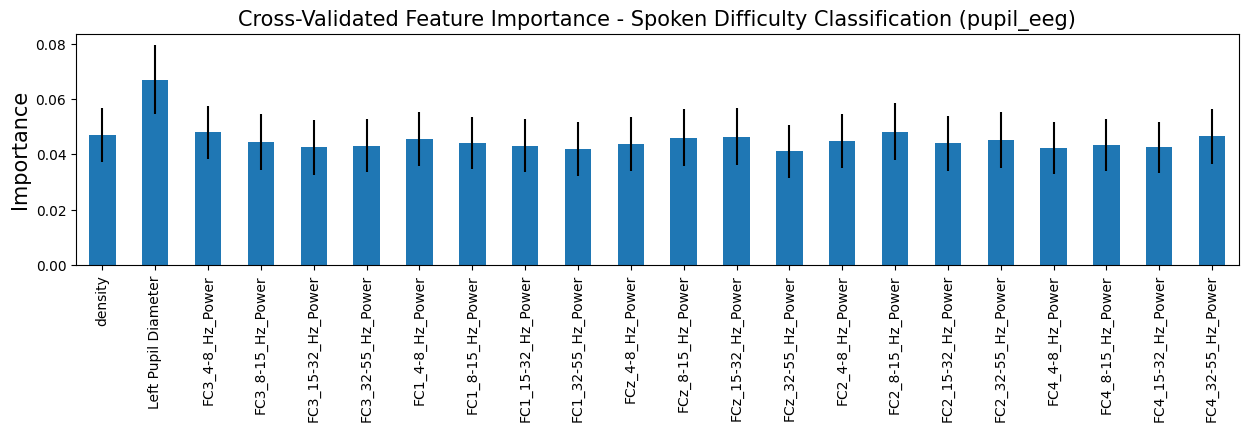

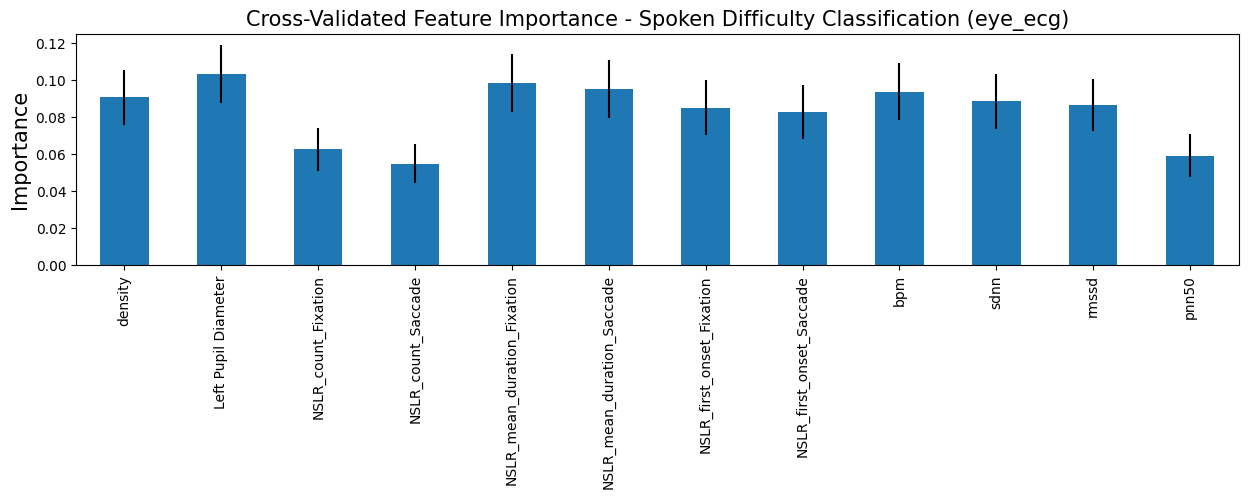

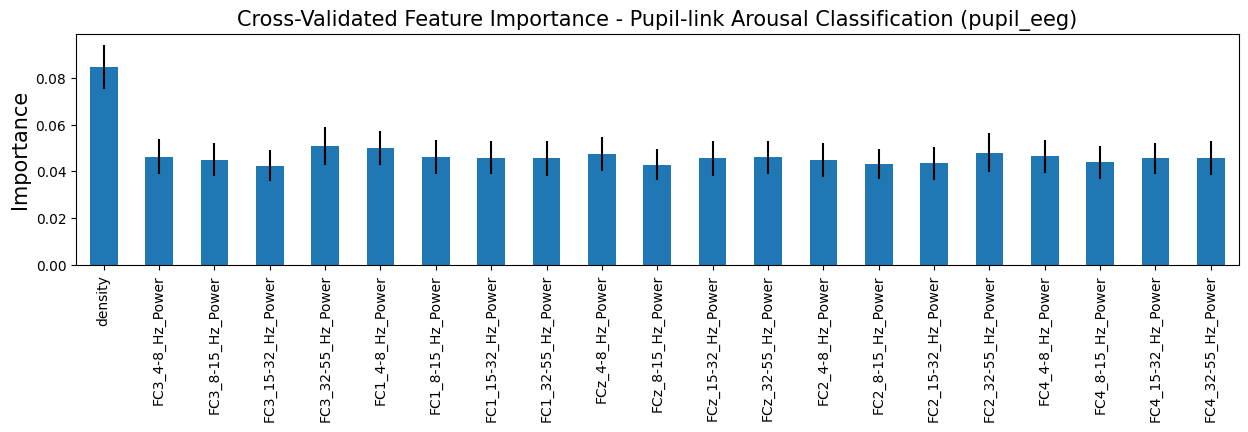

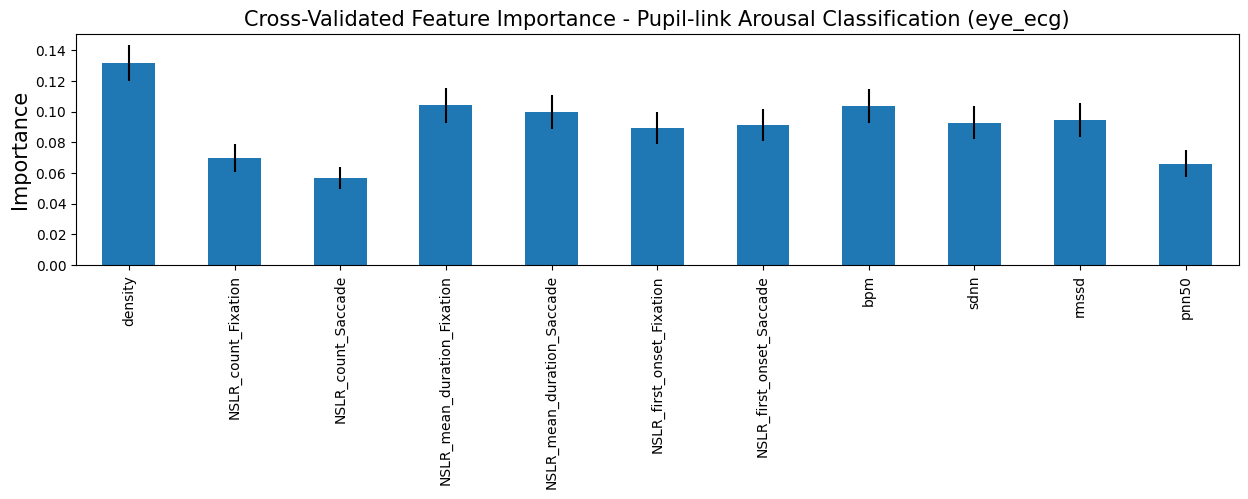

In [28]:
for idx, modalities_coefs in enumerate([modalities_coefs_voice, modalities_coefs_arousal]):

    for modalities in list(modalities_coefs_voice.keys()):

        importance_avg = np.mean(modalities_coefs[modalities], axis = 0)
        importance_std = np.std(modalities_coefs[modalities], axis = 0)

        if idx == 0: 
            clf_type = f"- Spoken Difficulty Classification ({modalities})"
            ci_type = ci_voice[modalities]
            if modalities is 'pupil_eeg':
                feature_list = features_voice[0]
            elif modalities is 'eye_ecg':
                feature_list = features_voice[1]
        elif idx == 1: 
            clf_type = f"- Pupil-link Arousal Classification ({modalities})"
            ci_type = ci_arousal[modalities]
            if modalities is 'pupil_eeg':
                feature_list = features_arousal[0]
            elif modalities is 'eye_ecg':
                feature_list = features_arousal[1]

        importance_plot(importance_avg, importance_std, ci_type, feature_list, plot_clf_type = clf_type, verification_method = 'cv')

### 3.1.2 Feature Permutation Importance

In [29]:
acc_df_voice_fpi, importance_permuted_voice_fpi, ci_voice_fpi, feature_list_voice_fpi = pred_func(all_dfs_cleaned_up, predictions = 'spoken_difficulty_encoded', 
                                                            verification_method='feature_permutation')
acc_df_arousal_fpi, importance_permuted_arousal_fpi, ci_arousal_fpi, feature_list_arousal_fpi = pred_func(all_dfs_cleaned_up, predictions = 'pupil_bin_encoded', 
                                                            verification_method='feature_permutation')

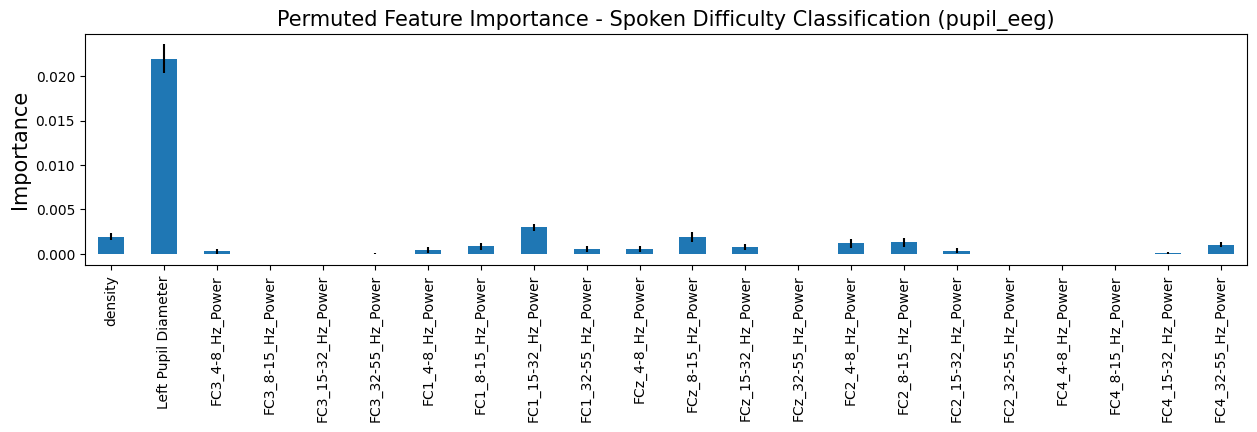

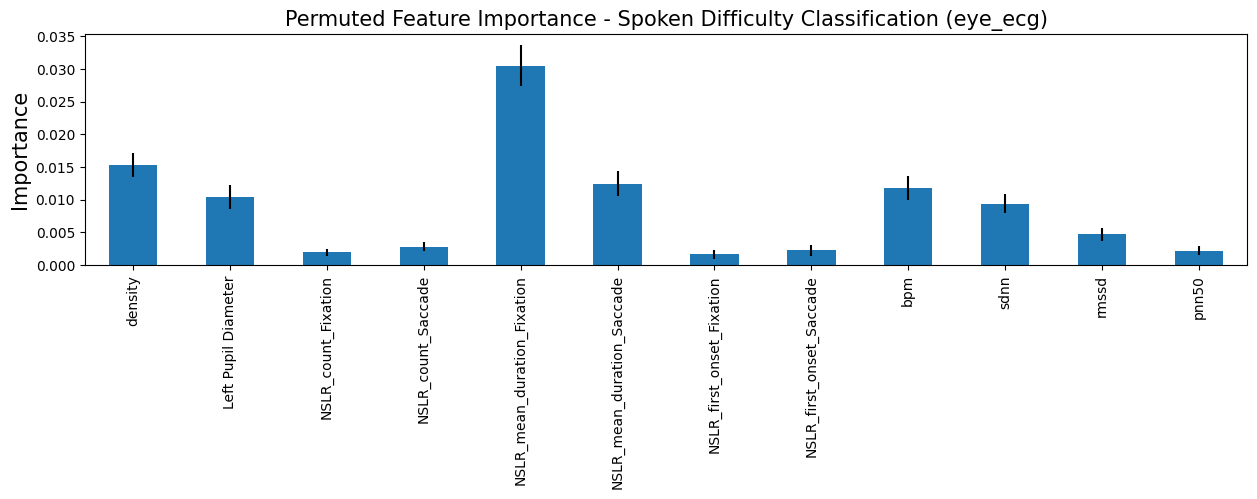

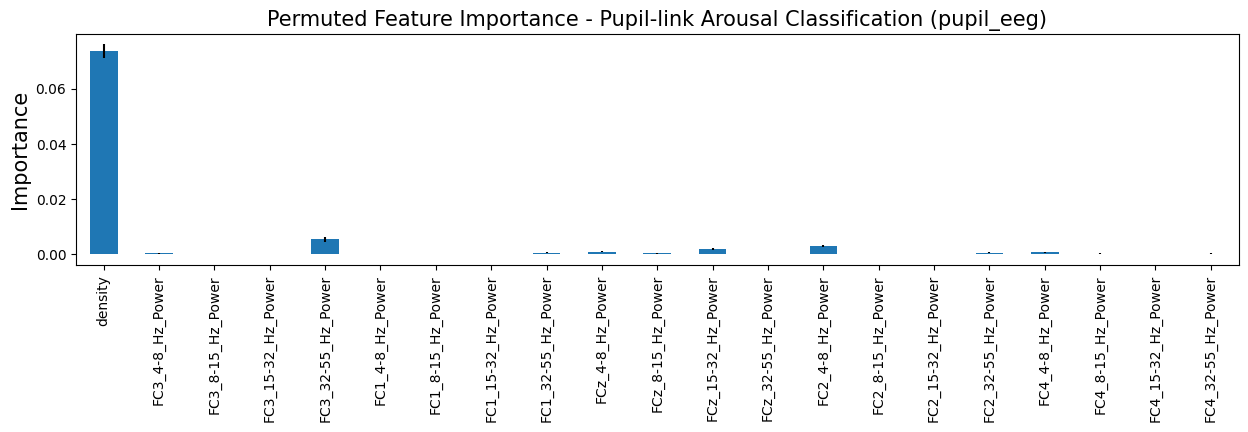

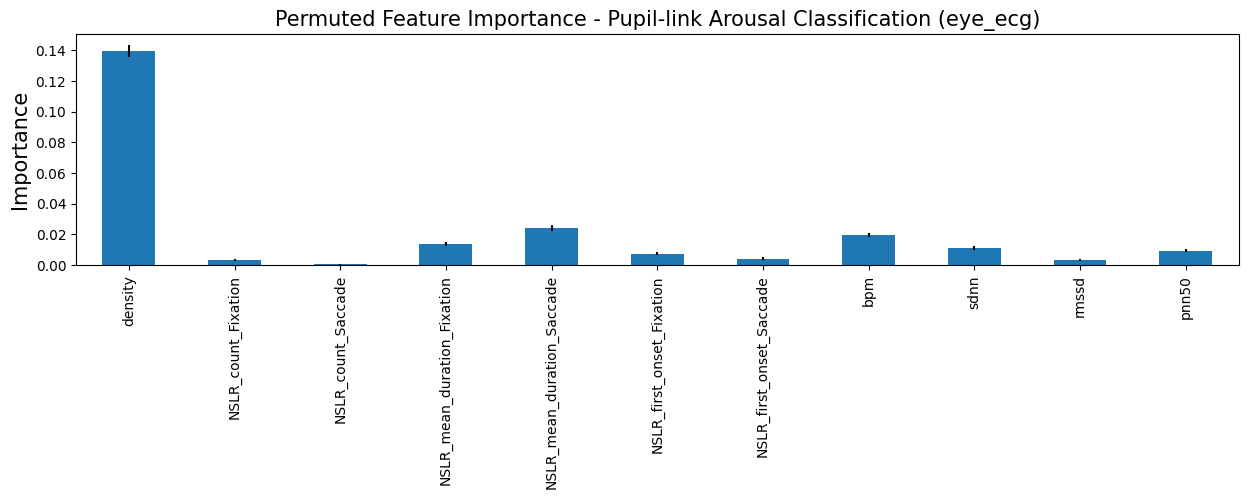

In [30]:
for idx, modalities_coefs in enumerate([importance_permuted_voice_fpi, importance_permuted_arousal_fpi]):

    for modalities in list(importance_permuted_voice_fpi.keys()):

        if idx == 0: 
            clf_type = f"- Spoken Difficulty Classification ({modalities})"
            ci_type = ci_voice_fpi[modalities]
            if modalities is 'pupil_eeg':
                feature_list = features_voice[0]
            elif modalities is 'eye_ecg':
                feature_list = features_voice[1]
        elif idx == 1: 
            clf_type = f"- Pupil-link Arousal Classification ({modalities})"
            ci_type = ci_arousal_fpi[modalities]
            if modalities is 'pupil_eeg':
                feature_list = features_arousal[0]
            elif modalities is 'eye_ecg':
                feature_list = features_arousal[1]

        importance_plot(modalities_coefs[modalities].importances_mean, modalities_coefs[modalities].importances_std, ci_type,
                        feature_list, plot_clf_type = clf_type, verification_method = 'feature_permutation')

### 3.1.3 Continuous Pupil Regression (WIP)

In [21]:
# rmse_mean = mean_squared_error(motor_all_dfs['steering_wheel_degree'], 
#                                motor_all_dfs['mean_steering_wheel_degree'], squared=False)

In [22]:
# mse_rmse, motor_reg_coefs, motor_reg_features = pred_func(motor_all_dfs, predictions = 'steering_wheel_degree', 
#                                    pred_type = 'regression')

In [23]:
# importance_motor_pred_avg = np.mean(motor_reg_coefs[0], axis = 0)
# importance_motor_pred_std = np.std(motor_reg_coefs[0], axis = 0)
# feature_list_motor_reg = motor_reg_features[0]

# cv_importance_plot(importance_motor_pred_avg, importance_motor_pred_std, feature_list_motor_reg)

In [24]:

# results_clf_reg.to_csv(f'../output/saved_files/all_modality_rmse_auc.csv')
# results_clf_reg.to_excel(f'../output/saved_files/all_modality_rmse_auc.xlsx')

## 3.2. Source Level

### 3.2.1 Dataframe processing - Source EEG Feature Addition

In [16]:
all_dfs_source = all_dfs_cleaned_up.copy()
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package)

Reading labels from parcellation...
   read 82 labels from /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /home/jiali/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot


In [17]:
output_dir = f'{path_to_base_package}/output/saved_files/pickle_files/corrected_voice_timestamp'
output_dir_non_baseline_non_average = f"{output_dir}/saved_files_non_baseline_non_average/" # saved files directory (trial or motor)

with open(f'{output_dir_non_baseline_non_average}/source_time_courses.pickle', 'rb') as handle:
    all_tcs = pickle.load(handle)

all_tcs = np.concatenate(all_tcs)

In [18]:
bands = [4, 8, 15, 32, 55]
band_intervals = list(zip(bands[:-1], bands[1:]))
brain_region_names = [f'{rel_mappings[rel_labels[i].name]}_{rel_labels[i].hemi}' for i in range(len(rel_labels))]
region_band_power = [f"{chan_name}_{each_band[0]}-{each_band[1]}_Hz_Power"
                            for chan_name in brain_region_names
                                for each_band in band_intervals]
band_power_all = np.empty([len(all_tcs), len(brain_region_names)*len(band_intervals)])
for i in range(len(all_tcs)):
    eeg_data = all_tcs[i,:]
    # Multitaper Method
    band_power = compute_pow_freq_bands(sfreq=128, data=eeg_data, freq_bands=band_intervals, normalize=True,
                                        psd_method = 'multitaper')
    band_power_all[i, :] = band_power
bpower_df = pd.DataFrame(band_power_all)
bpower_df.columns=region_band_power

all_dfs_tcs = pd.concat([all_dfs_source, bpower_df],axis=1)

In [22]:
predictors_tcs = ['density', 'Left Pupil Diameter'] + region_band_power
# predictors_tcs = predictors_tcs[12:22]

In [20]:
# all_dfs_tcs_voice = all_dfs_tcs[(all_dfs_tcs.spoken_difficulty_encoded.notnull()) & (all_dfs_tcs.spoken_difficulty_encoded != 0)]

### 3.2.2 Corss-validated prediction - Voice, Pupil-linked Arousal

In [23]:
acc_df_tcs_voice, modalities_coefs_tcs_voice, ci_voice_source, features_tcs_voice = pred_func(all_dfs_tcs, predictions = 'spoken_difficulty_encoded',
                                                                            predictors_1 = predictors_tcs)
acc_df_tcs_arousal, modalities_coefs_tcs_arousal, ci_pupil_source, features_tcs_arousal = pred_func(all_dfs_tcs, predictions = 'pupil_bin_encoded',
                                                                            predictors_1 = predictors_tcs)

In [24]:
print(f'The 10-fold cross validated test accuracy for spoken difficulty classification with EEG, pupil diameter, and density features: {acc_df_tcs_voice.pupil_eeg[1]:.4f}')
print(f'The 10-fold cross validated test accuracy for pupil link arousal classification with EEG, pupil diameter, and density features: {acc_df_tcs_arousal.pupil_eeg[1]:.4f}')
print(f'The 10-fold cross validated test accuracy for spoken difficulty classification with eye tracking, ECG, and density features: {acc_df_tcs_voice.eye_ecg[1]:.4f}')
print(f'The 10-fold cross validated test accuracy for pupil link arousal classification with eye tracking, ECG, and density features: {acc_df_tcs_arousal.eye_ecg[1]:.4f}')
# acc_df_tcs_voice, acc_df_tcs_arousal

The 10-fold cross validated test accuracy for spoken difficulty classification with EEG, pupil diameter, and density features: 0.5834
The 10-fold cross validated test accuracy for pupil link arousal classification with EEG, pupil diameter, and density features: 0.5902
The 10-fold cross validated test accuracy for spoken difficulty classification with eye tracking, ECG, and density features: 0.5441
The 10-fold cross validated test accuracy for pupil link arousal classification with eye tracking, ECG, and density features: 0.6008


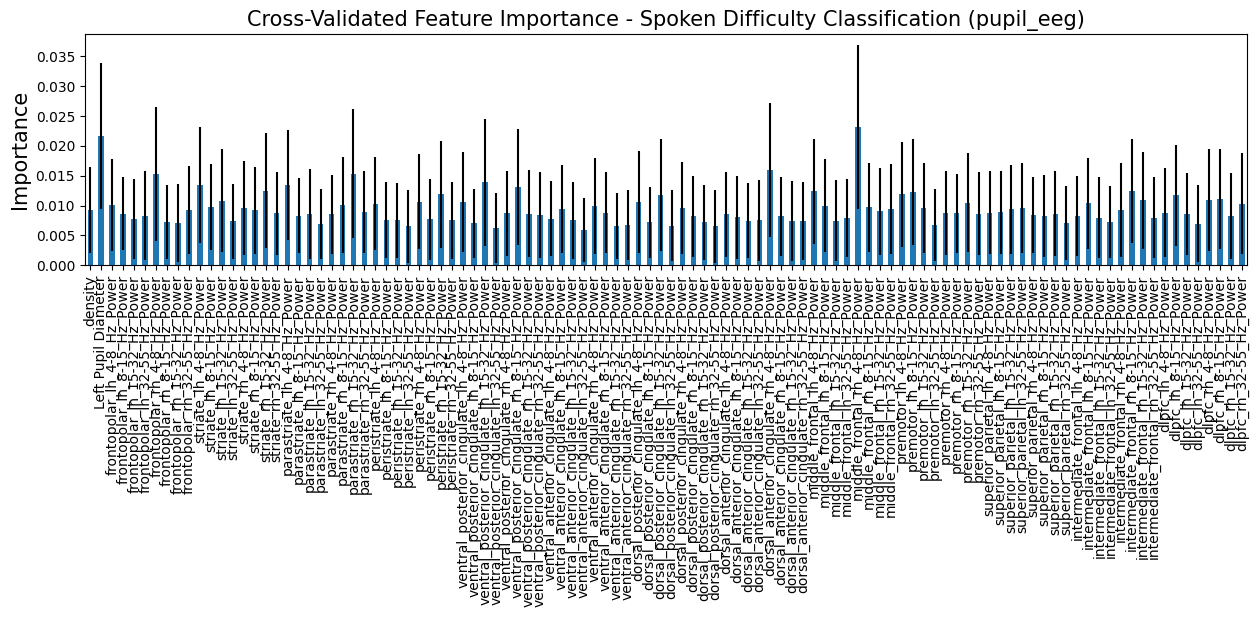

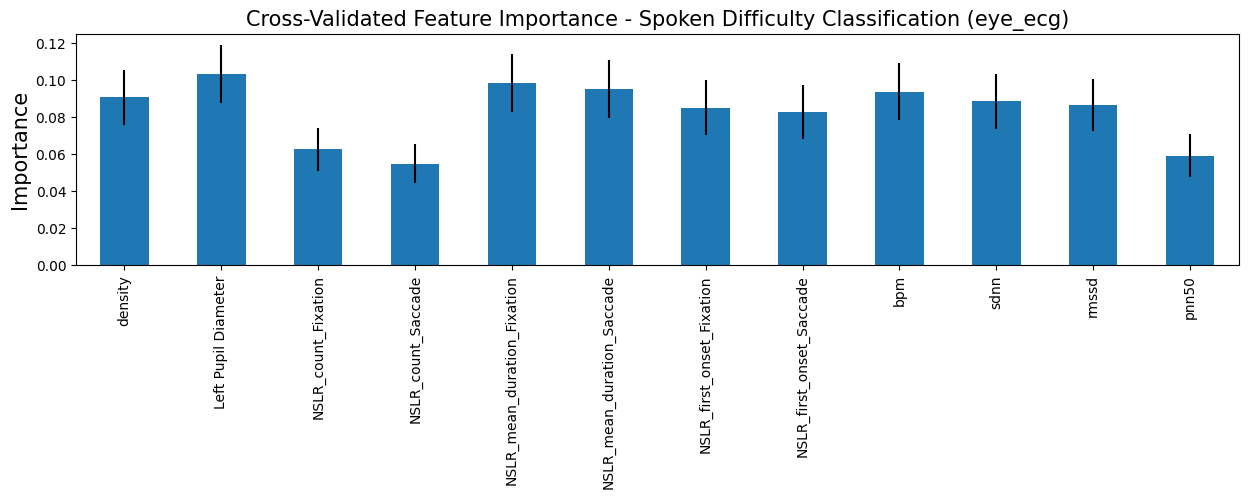

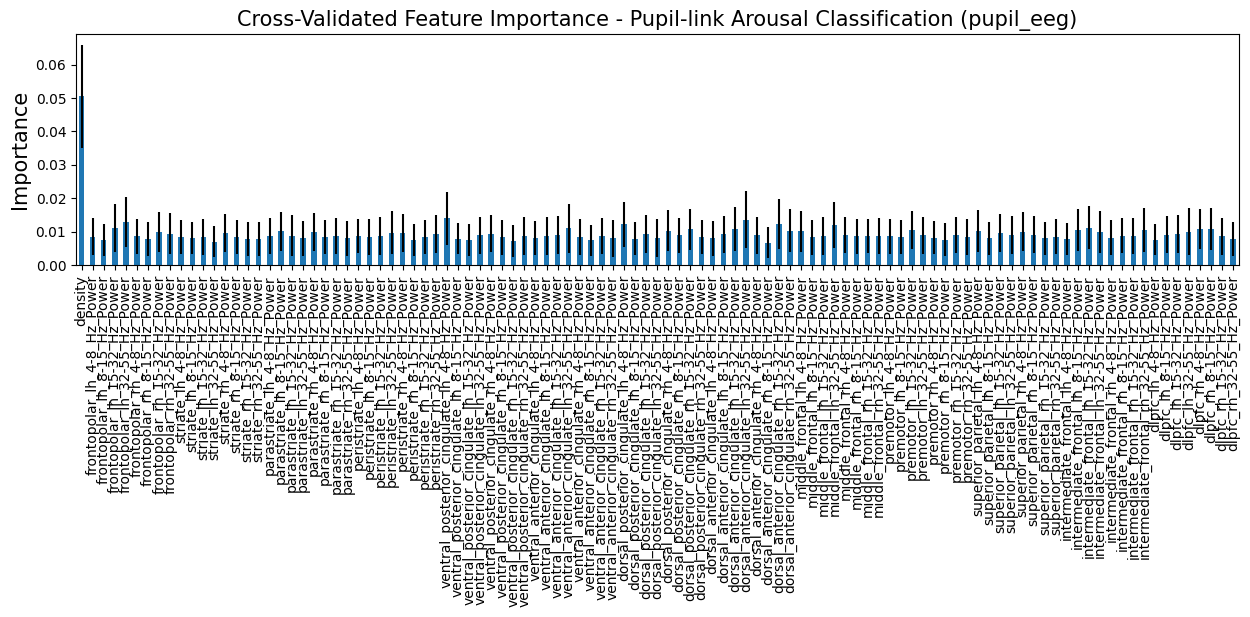

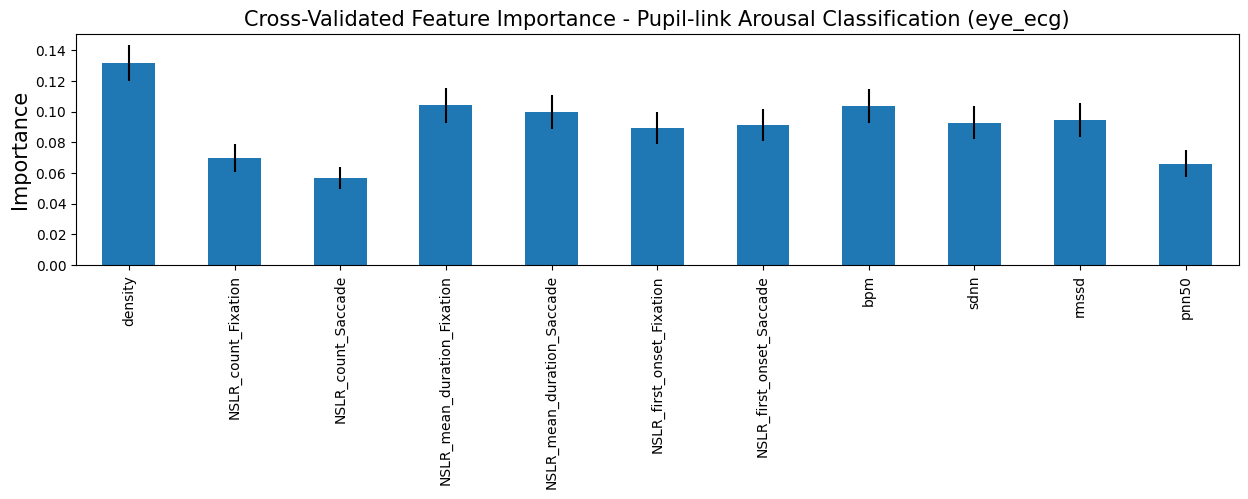

In [25]:
for idx, modalities_coefs in enumerate([modalities_coefs_tcs_voice, modalities_coefs_tcs_arousal]):

    for modalities in list(modalities_coefs_tcs_voice.keys()):

        importance_avg = np.mean(modalities_coefs[modalities], axis = 0)
        importance_std = np.std(modalities_coefs[modalities], axis = 0)

        if idx == 0: 
            clf_type = f"- Spoken Difficulty Classification ({modalities})"
            ci_type = ci_voice_source[modalities]
            if modalities is 'pupil_eeg':
                feature_list_tcs = features_tcs_voice[0]
            elif modalities is 'eye_ecg':
                feature_list_tcs = features_tcs_voice[1]
        elif idx == 1: 
            clf_type = f"- Pupil-link Arousal Classification ({modalities})"
            ci_type = ci_pupil_source[modalities]
            if modalities is 'pupil_eeg':
                feature_list_tcs = features_tcs_arousal[0]
            elif modalities is 'eye_ecg':
                feature_list_tcs = features_tcs_arousal[1]
        importance_plot(importance_avg, importance_std, ci_type, feature_list_tcs, plot_clf_type = clf_type, verification_method='cv')


### 3.2.3 Feature Permutation Importance

In [45]:
tcs_acc_df_voice_fpi, tcs_importance_permuted_voice_fpi, tcs_ci_voice_fpi, tcs_feature_list_voice_fpi = pred_func(all_dfs_tcs, predictions = 'spoken_difficulty_encoded', 
                                                            predictors_1 = predictors_tcs, verification_method='feature_permutation')
# tcs_acc_df_arousal_fpi, tcs_importance_permuted_arousal_fpi, tcs_ci_arousal_fpi, tcs_feature_list_arousal_fpi = pred_func(all_dfs_tcs, predictions = 'pupil_bin_encoded', 
                                                            # predictors_1 = predictors_tcs, verification_method='feature_permutation')

In [46]:
# 12 features (second 12)
tcs_importance_permuted_voice_fpi['pupil_eeg']

{'importances_mean': array([0.00859922, 0.002607  , 0.04249027, 0.01645914, 0.0451751 ,
        0.00143969, 0.02560311, 0.01361868, 0.00342412, 0.00272374]),
 'importances_std': array([0.0048691 , 0.00198825, 0.00916968, 0.00443153, 0.00949759,
        0.00210656, 0.00630254, 0.00487547, 0.00362014, 0.00202185]),
 'importances': array([[0.0077821 , 0.0077821 , 0.01945525, 0.0077821 , 0.0077821 ,
         0.01167315, 0.00389105, 0.00389105, 0.0155642 , 0.0077821 ,
         0.00389105, 0.0077821 , 0.00389105, 0.        , 0.0077821 ,
         0.0077821 , 0.01167315, 0.0077821 , 0.01167315, 0.01167315,
         0.        , 0.0077821 , 0.0077821 , 0.01167315, 0.00389105,
         0.01167315, 0.0077821 , 0.0077821 , 0.0077821 , 0.00389105,
         0.0077821 , 0.0155642 , 0.0155642 , 0.01945525, 0.0077821 ,
         0.        , 0.00389105, 0.0077821 , 0.0077821 , 0.01167315,
         0.0155642 , 0.01945525, 0.0077821 , 0.0077821 , 0.01167315,
         0.01167315, 0.0077821 , 0.        , 0.  

In [42]:
# 12 features (first 12)
tcs_importance_permuted_voice_fpi['pupil_eeg']

{'importances_mean': array([0.        , 0.06089494, 0.00307393, 0.00151751, 0.00377432,
        0.00031128, 0.02848249, 0.00381323, 0.00229572, 0.00229572,
        0.02093385, 0.00684825]),
 'importances_std': array([0.        , 0.01128237, 0.00292709, 0.00219388, 0.00260758,
        0.00119043, 0.00887091, 0.00245969, 0.00246675, 0.0025866 ,
        0.00485306, 0.00352865]),
 'importances': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.04669261, 0.05836576, 0.05447471, ..., 0.05836576, 0.06225681,
         0.07782101],
        [0.00389105, 0.0077821 , 0.00389105, ..., 0.00389105, 0.0077821 ,
         0.        ],
        ...,
        [0.        , 0.00389105, 0.00389105, ..., 0.00389105, 0.        ,
         0.0077821 ],
        [0.0233463 , 0.0233463 , 0.01167315, ..., 0.0233463 , 0.0311284 ,
         0.0311284 ],
        [0.01167315, 0.01167315, 0.00389105, ..., 0.0077821 , 0.0077821 ,
         0.0077821 ]])}

In [36]:
# 22 features
tcs_importance_permuted_voice_fpi['pupil_eeg']

{'importances_mean': array([0.        , 0.01933852, 0.00019455, 0.        , 0.        ,
        0.        , 0.00319066, 0.        , 0.        , 0.        ,
        0.00287938, 0.00015564, 0.        , 0.        , 0.        ,
        0.        , 0.00774319, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 'importances_std': array([0.        , 0.00761404, 0.00084803, 0.        , 0.        ,
        0.        , 0.00287938, 0.        , 0.        , 0.        ,
        0.00267437, 0.00076249, 0.        , 0.        , 0.        ,
        0.        , 0.00455419, 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 'importances': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.01167315, 0.01167315, 0.0077821 , ..., 0.01945525, 0.0311284 ,
         0.0155642 ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 

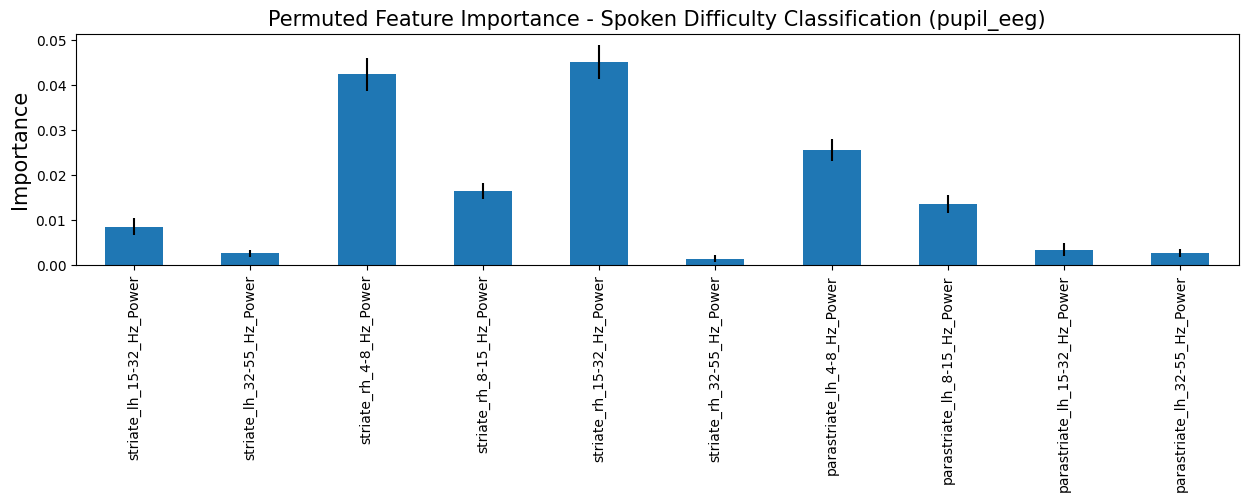

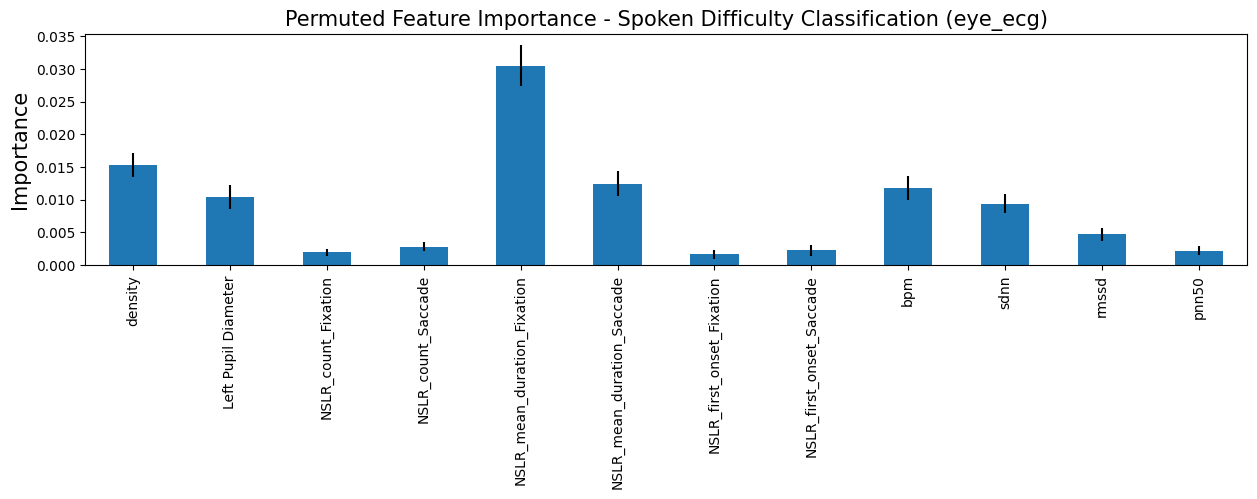

In [47]:
# [tcs_importance_permuted_voice_fpi, tcs_importance_permuted_arousal_fpi]
for idx, modalities_coefs in enumerate([tcs_importance_permuted_voice_fpi]):

    for modalities in list(tcs_importance_permuted_voice_fpi.keys()):

        if idx == 0: 
            clf_type = f"- Spoken Difficulty Classification ({modalities})"
            ci_type = tcs_ci_voice_fpi[modalities]
            if modalities is 'pupil_eeg':
                tcs_feature_list_fpi = tcs_feature_list_voice_fpi[0]
            elif modalities is 'eye_ecg':
                tcs_feature_list_fpi = tcs_feature_list_voice_fpi[1]
        # elif idx == 1: 
        #     clf_type = f"- Pupil-link Arousal Classification ({modalities})"
        #     if modalities is 'pupil_eeg':
        #         tcs_feature_list_fpi = tcs_feature_list_arousal_fpi[0]
        #     elif modalities is 'eye_ecg':
        #         tcs_feature_list_fpi = tcs_feature_list_arousal_fpi[1]

        importance_plot(modalities_coefs[modalities].importances_mean, modalities_coefs[modalities].importances_std,
                        ci_type, tcs_feature_list_fpi, plot_clf_type = clf_type, verification_method='feature_permutation')

### 3.2.4 Continuous Pupil Regression